In [1]:
import time
from typing import Optional, Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

# Mobilenet v1: [https://arxiv.org/abs/1704.04861](https://arxiv.org/abs/1704.04861)

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.__version__

'1.13.1+cu117'

In [4]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root='../models/mnist',
    train=True,
    transform=ToTensor(),
    download=True,
)

test_data = datasets.MNIST(
    root='../models/mnist',
    train=False,
    transform=ToTensor(),
    download=True,
)

In [5]:
class TrainHelper:
    @staticmethod
    def train(cnn: nn.Module,
              *,
              epochs: int,
              train_dataset: datasets.MNIST,
              test_dataset: Optional[datasets.MNIST] = None,
              print_results: bool = True,
              batch_size: int,
              device_name: str) -> List[float]:

        train_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=1)

        device = torch.device(device_name)

        cnn.to(device)
        cnn.train()

        optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
        loss_func = nn.CrossEntropyLoss()

        eval_results: List[float] = []

        for epoch in range(epochs):
            for images, labels in train_loader:
                images = Variable(images.to(device))
                labels = Variable(labels.to(device))

                output = cnn(images)
                loss = loss_func(output, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if test_dataset is not None:
                eval_result = TrainHelper.test(cnn, test_dataset, device)
                eval_results.append(eval_result)
                if print_results:
                    print(f"epoch {epoch}, accuracy = {eval_result}, loss = {loss.detach()}")
                cnn.train()

        return eval_results

    @staticmethod
    def test(cnn: nn.Module, test_dataset: datasets.MNIST, device=None) -> float:
        cnn.eval()
        loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=1)
        correct = 0
        incorrect = 0

        for images, labels in loader:
            if device is not None:
                images = images.to(device)

            results = cnn(images)
            predictions = results.detach().cpu().numpy().argmax(axis=1)
            oks = (predictions == labels.numpy()).sum()
            correct += oks
            incorrect += len(predictions) - oks

        return correct / (correct + incorrect)

    @staticmethod
    def train_models(models: List[nn.Module], device_name: str) -> Tuple[int, float]:
        """
        generator yields pair (trainable parameters count, best accuracy) for each network
        :param device_name: 'cuda' or 'cpu'
        """
        assert len(models) > 0

        for model in models:
            start = time.time()
            eval_results = TrainHelper.train(
                cnn=model,
                epochs=20,
                train_dataset=train_data,
                test_dataset=test_data,
                batch_size=1024,
                device_name=device_name,
                print_results=False
            )
            end = time.time()
            best_acc = max(eval_results)
            params_count = TrainHelper.total_parameters_count(model)
            print(f"best accuracy = {best_acc}, parameters = {params_count}, training time = {end - start}")
            yield params_count, best_acc

    @staticmethod
    def total_parameters_count(model: nn.Module) -> int:
        return sum(np.prod(p.size()) for p in model.parameters())

    @staticmethod
    def print_parameters(model: nn.Module):
        print(f"total parameters = {TrainHelper.total_parameters_count(model)}")
        for p in model.parameters():
            print(f"size {np.prod(p.size())}: {p.size()}")

In [6]:
class MyMobileNetV1(nn.Module):
    def __init__(self, channels: int, nonlinear_mid: bool):
        super(MyMobileNetV1, self).__init__()
        self.nonlinear_mid = nonlinear_mid

        c = channels
        self.layers = nn.Sequential(
            nn.Conv2d(1, c, groups=1, kernel_size=3, padding='valid', bias=False),         # 28 - 26
            nn.BatchNorm2d(c),
            nn.LeakyReLU(0.1),

            self.conv(c, c, kernel_size=3),         # 26 - 24
            nn.MaxPool2d(2),                        # 24 - 12

            self.conv(c, c * 2, kernel_size=3),     # 12 - 10
            self.conv(c * 2, c * 2, kernel_size=3), # 10 - 8
            nn.MaxPool2d(2),                        # 8 - 4

            self.conv(c * 2, c * 4, kernel_size=3), # 4 - 2
            self.conv(c * 4, c * 4, kernel_size=2), # 2 - 1

            nn.Conv2d(c * 4, 10, kernel_size=1, padding='valid', bias=True),
            nn.Flatten(),
        )

    def conv(self, in_ch: int, out_ch: int, *, kernel_size):
        depthwise_conv = nn.Conv2d(in_ch, in_ch, groups=in_ch , kernel_size=kernel_size, padding='valid', bias=False)
        channelwise_conv = nn.Conv2d(in_ch, out_ch, groups=1, kernel_size=1, padding='valid', bias=False)

        if self.nonlinear_mid:
            return nn.Sequential(
                depthwise_conv,
                nn.BatchNorm2d(in_ch),
                nn.LeakyReLU(0.1),
                channelwise_conv,
                nn.BatchNorm2d(out_ch),
                nn.LeakyReLU(0.1)
            )
        else:
            return nn.Sequential(
                depthwise_conv,
                channelwise_conv,
                nn.BatchNorm2d(out_ch),
                nn.LeakyReLU(0.1)
            )

    def forward(self, x: torch.Tensor):
        return self.layers(x)

In [7]:
results_no_mid = []
results_nonlinear_mid = []
channel_counts = [4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128]

In [8]:
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'

for i in range(4):
    for pair in TrainHelper.train_models([MyMobileNetV1(n, nonlinear_mid=False) for n in channel_counts], device_name=device_name):
        results_no_mid.append(pair)

best accuracy = 0.9709, parameters = 1094, training time = 84.41824269294739
best accuracy = 0.9808, parameters = 2008, training time = 82.86199283599854
best accuracy = 0.987, parameters = 3170, training time = 82.6839599609375
best accuracy = 0.9889, parameters = 6238, training time = 82.96412301063538
best accuracy = 0.9908, parameters = 10298, training time = 83.09248471260071
best accuracy = 0.9931, parameters = 21394, training time = 82.90012979507446
best accuracy = 0.9921, parameters = 36458, training time = 83.32740616798401
best accuracy = 0.9928, parameters = 78490, training time = 83.71057772636414
best accuracy = 0.9925, parameters = 136394, training time = 83.92194056510925
best accuracy = 0.9935, parameters = 299818, training time = 101.42006301879883
best accuracy = 0.9947, parameters = 526730, training time = 134.1332733631134
best accuracy = 0.9713, parameters = 1094, training time = 84.47342872619629
best accuracy = 0.9811, parameters = 2008, training time = 84.32501

In [9]:
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'

for i in range(4):
    for pair in TrainHelper.train_models([MyMobileNetV1(n, nonlinear_mid=True) for n in channel_counts], device_name=device_name):
        results_nonlinear_mid.append(pair)

best accuracy = 0.957, parameters = 1174, training time = 85.45157837867737
best accuracy = 0.9749, parameters = 2128, training time = 84.91150736808777
best accuracy = 0.9812, parameters = 3330, training time = 84.4858603477478
best accuracy = 0.9854, parameters = 6478, training time = 84.73620557785034
best accuracy = 0.9874, parameters = 10618, training time = 85.04801774024963
best accuracy = 0.9878, parameters = 21874, training time = 84.97305178642273
best accuracy = 0.9882, parameters = 37098, training time = 84.75248599052429
best accuracy = 0.989, parameters = 79450, training time = 84.60826373100281
best accuracy = 0.9913, parameters = 137674, training time = 85.28315997123718
best accuracy = 0.9928, parameters = 301738, training time = 114.94288349151611
best accuracy = 0.9922, parameters = 529290, training time = 151.54352378845215
best accuracy = 0.9635, parameters = 1174, training time = 86.24637532234192
best accuracy = 0.9726, parameters = 2128, training time = 85.91931

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


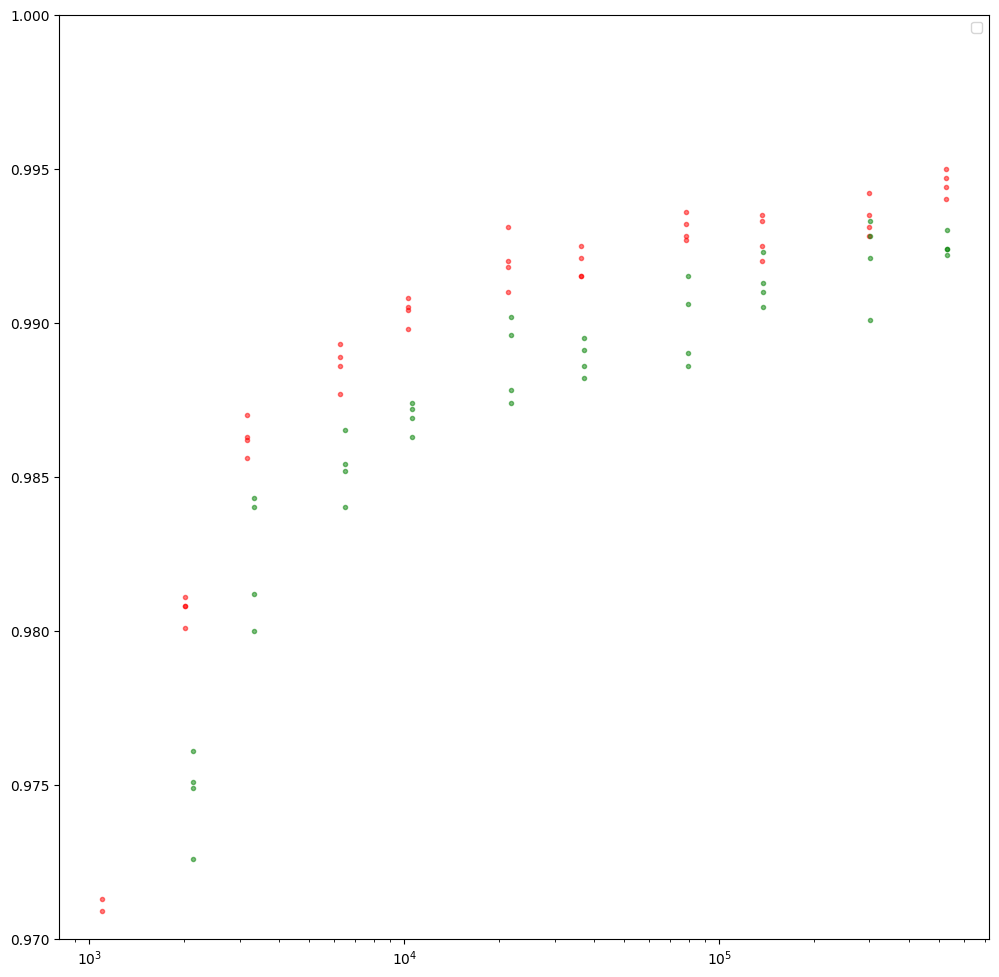

In [10]:
plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_ylim(0.97, 1)

ax.scatter([p[0] for p in results_no_mid], [p[1] for p in results_no_mid], c='red', alpha=0.5, marker=r'.')
ax.scatter([p[0] for p in results_nonlinear_mid], [p[1] for p in results_nonlinear_mid], c='green', alpha=0.5, marker=r'.')

ax.legend()
plt.show()

Combination of channelwise and depthwise convolution works better without activation layer between them on my example. It's quite surprising result because original mobilenet article proposes to use activation between them.  

May be my implementation is incorrect.